In [47]:
# import data handling tools
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input, Dense, Activation, Dropout, BatchNormalization,  GlobalAveragePooling2D
from tensorflow.keras import regularizers
import itertools

from google.colab import drive
drive.mount('/content/drive')

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
modules loaded


**Data Preprocessing**

Read Data ans store it in dataframe

In [33]:
# Generate data paths with labels
data_dir = '/content/drive/My Drive/With Noise Pest Disease'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [34]:
df

,filepaths,labels
0,/content/drive/My Drive/Pest Disease/No Pest/2...,No Pest
1,/content/drive/My Drive/Pest Disease/No Pest/2...,No Pest
2,/content/drive/My Drive/Pest Disease/No Pest/2...,No Pest
3,/content/drive/My Drive/Pest Disease/No Pest/2...,No Pest
4,/content/drive/My Drive/Pest Disease/No Pest/2...,No Pest
...,...,...
988,/content/drive/My Drive/Pest Disease/Mango Lea...,Mango Leafhoppers
989,/content/drive/My Drive/Pest Disease/Mango Lea...,Mango Leafhoppers
990,/content/drive/My Drive/Pest Disease/Mango Lea...,Mango Leafhoppers
991,/content/drive/My Drive/Pest Disease/Mango Lea...,Mango Leafhoppers


**Split dataframe into train, valid, and test**

In [35]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

**Create image data generator**

In [36]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 794 validated image filenames belonging to 2 classes.
Found 119 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.


**Show sample from train data**

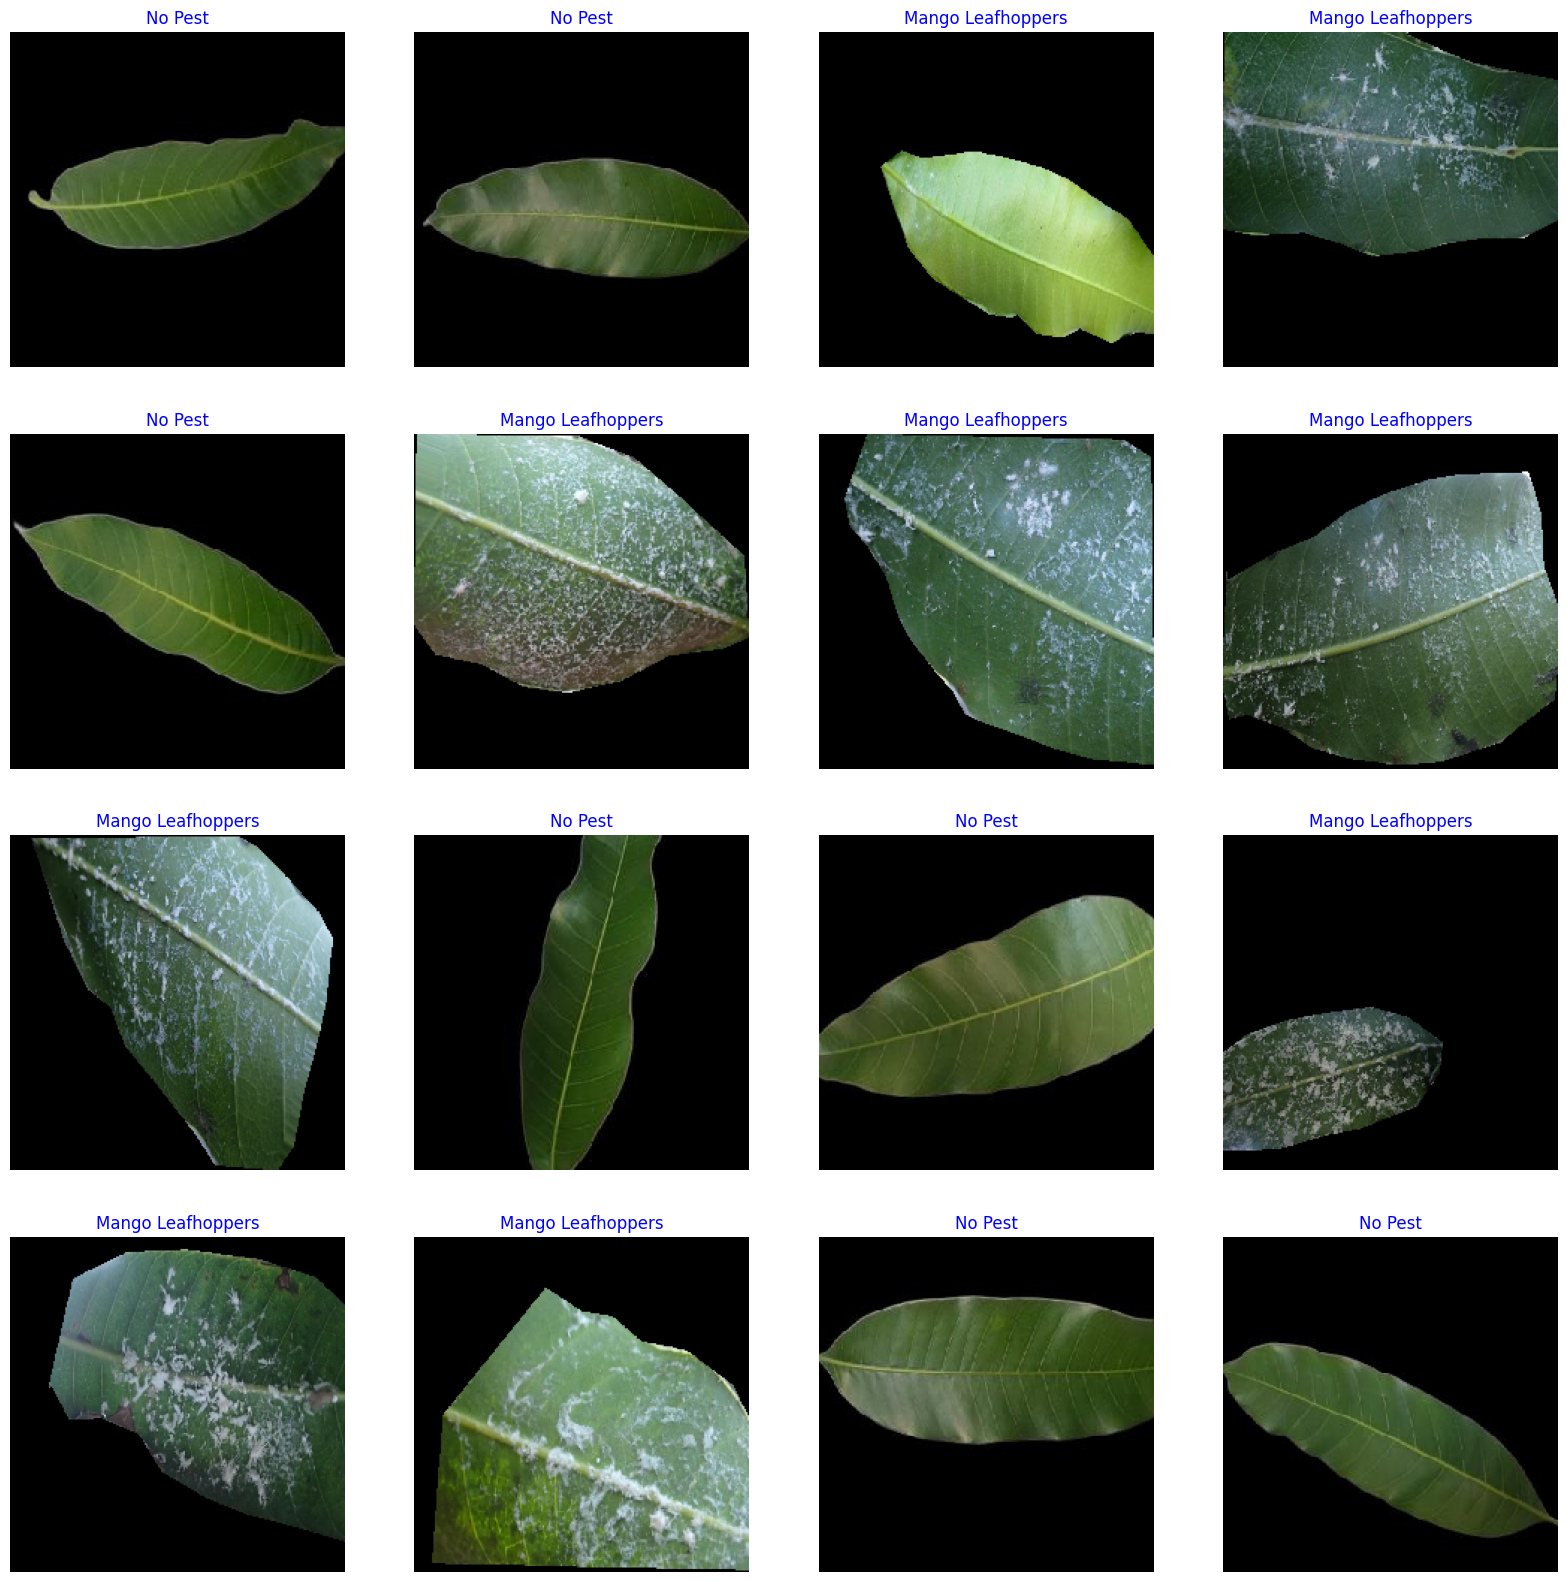

In [37]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**
Generic Model Creation

In [38]:
# Create Model Structure
# Define image size and model parameters
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Number of classes for the output layer

# Define the input
inputs = Input(shape=img_shape)

# Load pre-trained EfficientNetB0 model without the top classification layers
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights="imagenet", input_tensor=inputs)

# Add GlobalAveragePooling2D to flatten the output of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add BatchNormalization layer
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

# Add Dense layer with regularization
x = Dense(256,
          kernel_regularizer=regularizers.l2(l2=0.016),  # Correct l2 regularization
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu')(x)

# Add Dropout for regularization
x = Dropout(rate=0.45, seed=123)(x)

# Add final Dense layer for classification
outputs = Dense(class_count, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the structure
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_14 (Rescaling)  │ (None, 224, 224, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_7           │ (None, 224, 224, 3)    │              7 │ rescaling_14[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_15 (Rescaling)  │ (None, 224, 224, 3)    │              0 │ normalization_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_15[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,383,141 (16.72 MB)

 Trainable params: 4,338,558 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

**Train Model**

In [40]:
batch_size = 16   # set batch size for training
epochs = 20   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.6071 - loss: 3.3598 - val_accuracy: 0.6134 - val_loss: 3.7339
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5807 - loss: 3.1014 - val_accuracy: 0.8235 - val_loss: 3.3041
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6770 - loss: 2.8681 - val_accuracy: 0.5966 - val_loss: 3.0653
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.6641 - loss: 2.6587 - val_accuracy: 0.6387 - val_loss: 2.7356
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.6541 - loss: 2.4680 - val_accuracy: 0.7479 - val_loss: 2.6014
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.7683 - loss: 2.2873 - val_accuracy: 0.6387 - val_loss: 2.3413
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.7663 - loss: 2.1341 - val_accuracy: 0.9664 - val_loss: 2.2408
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9127 - loss: 1.9719 - val_accuracy: 0.

**Display Model Performance**

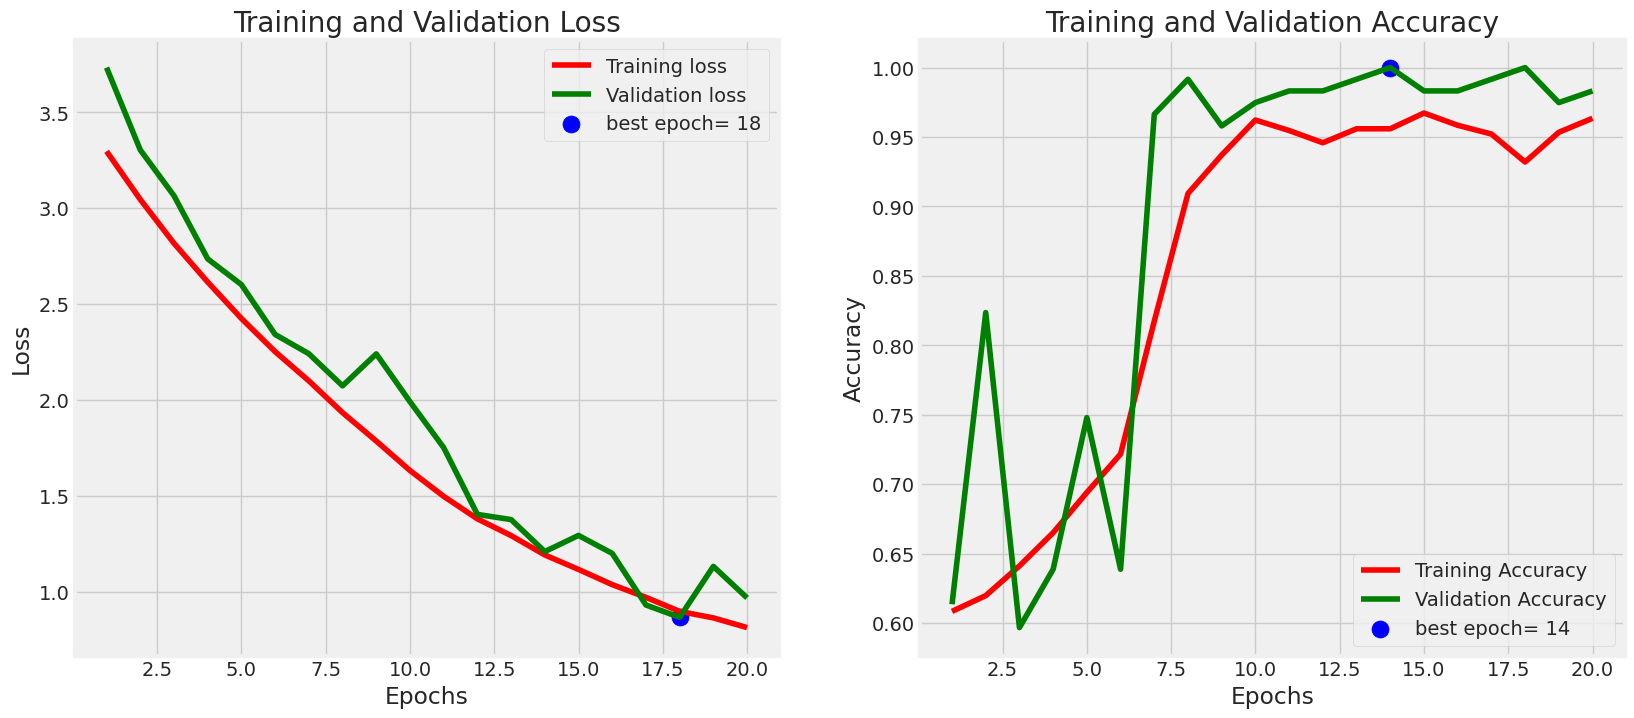

In [41]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

**Evaluate Model**

In [42]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9375 - loss: 1.1471
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.8183
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.9875 - loss: 2.5975
Train Loss:  1.1471484899520874
Train Accuracy:  0.9375
--------------------
Validation Loss:  0.8183263540267944
Validation Accuracy:  1.0
--------------------
Test Loss:  2.5975255966186523
Test Accuracy:  0.987500011920929


**Get Predictions**

In [44]:
# Predict using model.predict() instead of predict_generator()
preds = model.predict(test_gen)

# Get the index of the highest probability (class prediction)
y_pred = np.argmax(preds, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


**Confusion Matrics and Classification Report**

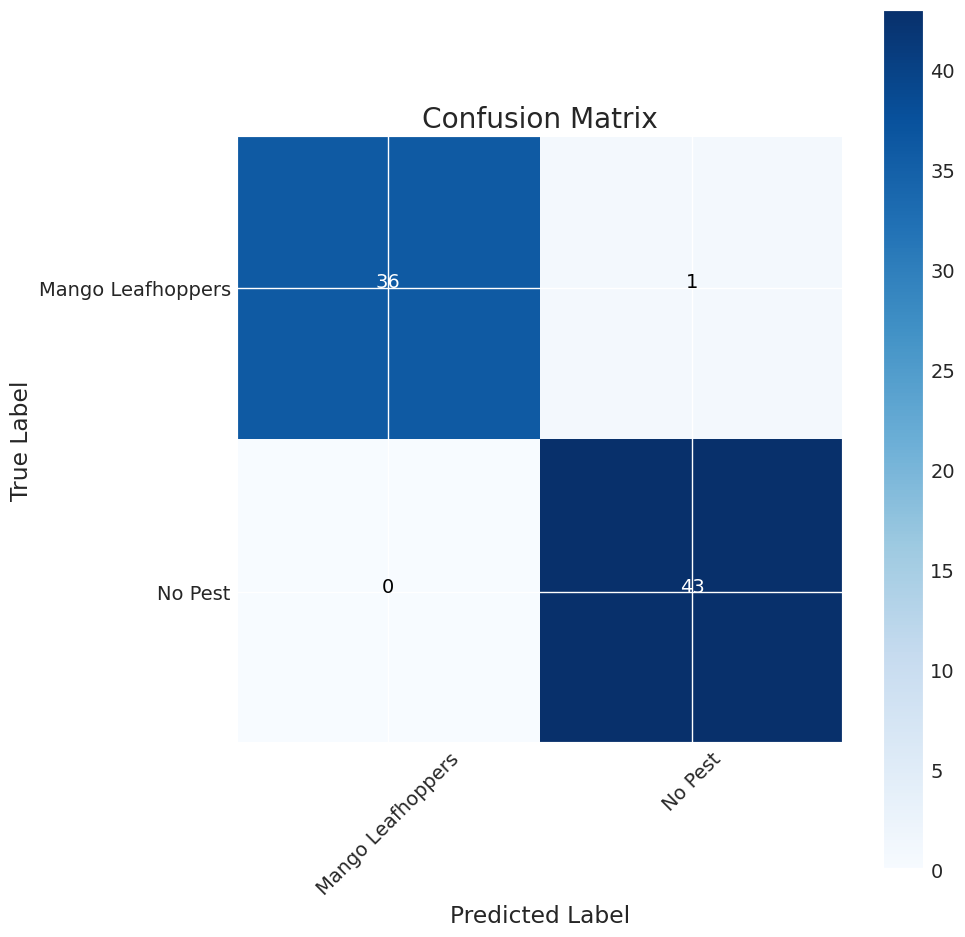

In [48]:
# Assuming test_gen and y_pred are already defined
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add labels to confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [49]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                   precision    recall  f1-score   support

Mango Leafhoppers       1.00      0.97      0.99        37
          No Pest       0.98      1.00      0.99        43

         accuracy                           0.99        80
        macro avg       0.99      0.99      0.99        80
     weighted avg       0.99      0.99      0.99        80

